In [1]:
%matplotlib inline

This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from retina import MotionCloudNoise, get_data_loader

# display images

#### MNIST dataset read out

In [3]:
import torch


In [4]:
loader = get_data_loader(batch_size=100, train=False)

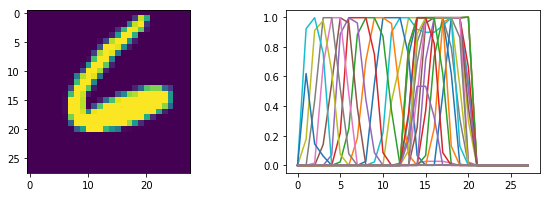

In [26]:
data, label = next(iter(loader))
plt.figure(figsize = (10,3))
plt.subplot(121)
plt.imshow(data[0,0,:,:])
plt.subplot(122)
_ = plt.plot(data[0,0,:,:].numpy())

# foveation

In [6]:
from retina import vectorization

In [7]:
N_theta = 6
N_azimuth = 16
N_eccentricity = 10
N_phase = 2
N_X = 128
N_Y = 128
rho = 1.41
verbose = 1


#### Full encoding

In [8]:
retina = vectorization(N_theta, N_azimuth, N_eccentricity, N_phase, N_X, N_Y, rho)
print(retina.shape)

(6, 16, 10, 2, 16384)


In [9]:
retina_vector = retina.reshape((N_theta*N_azimuth*N_eccentricity*N_phase, N_X*N_Y))
print(retina_vector.shape)

(1920, 16384)


In [10]:
retina_inverse = np.linalg.pinv(retina_vector)
print(retina_inverse.shape)

(16384, 1920)


#### Orientation invariant power encoding (colliculus??)

In [11]:
colliculus = (retina**2).sum(axis=(0, 3))
#colliculus = colliculus**.5
colliculus /= colliculus.sum(axis=-1)[:, :, None]
print(colliculus.shape)

(16, 10, 16384)


In [12]:
colliculus_vector = colliculus.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
print(colliculus_vector.shape)

(160, 16384)


In [13]:
colliculus_inverse = np.linalg.pinv(colliculus_vector)
print(colliculus_inverse.shape)

(16384, 160)


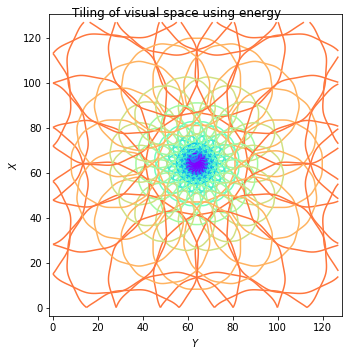

In [14]:
energy = (retina**2).sum(axis=(0,3)) 
energy /= energy.sum(axis=-1)[:, :, None]
energy_vector = energy.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
energy_plus = np.linalg.pinv(energy_vector)
FIG_WIDTH = 5 

fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
for i_orient in range(N_azimuth):
    for i_scale in range(N_eccentricity):
        env = np.sqrt(energy[i_orient, i_scale, :]**2.5).reshape((N_X, N_Y))
        ax.contour(energy[i_orient, i_scale, :].reshape((N_X, N_Y)), levels=[env.max()/2], lw=1,
                  colors=[plt.cm.rainbow(i_scale * 1.5/N_azimuth)])
fig.suptitle('Tiling of visual space using energy')
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout()

# summary

In [15]:
import tikzmagic

In [16]:
%load_ext tikzmagic

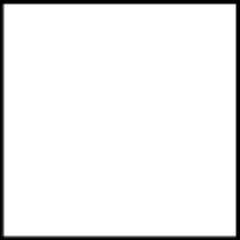

In [17]:
%%tikz 
\draw (0,0) rectangle (1,1);

In [18]:
%load_ext version_information
%version_information numpy, tikzmagic

Software versions
Python 3.7.2 64bit [Clang 10.0.0 (clang-1000.11.45.5)]
IPython 7.3.0
OS Darwin 18.2.0 x86_64 i386 64bit
numpy 1.16.2
tikzmagic 0.1.1
Tue Mar 05 12:47:12 2019 CET

# protocol_recording

In [19]:
figname = '../paper/fig_intro'

In [20]:
!rm  -f {figname}*

In [21]:
%%tikz  -l arrows.meta --scale 15 -f pdf -S {figname}.pdf

\def\Titre{6}
\def\sousTitre{4}
\def\text{4}

\def\a{0.3} % ecart horizontal
\def\b{0.1} % ecart vertical

% \draw (.85, 4.15) rectangle (1.25, 4.35);

\draw [line width=0.1mm, color=black!75!white, fill=black!50!white] (0, -0.5) rectangle (1, 0.5);
\filldraw [white] (0.5, 0) circle (.02);
\draw [white] (0.5, 0.1) node[above, scale=\Titre, font =\sffamily] {FIXATION};
\draw [white] (0.5, -0.1) node[below, scale=\sousTitre, font =\sffamily] {(ramdom)};

\draw [line width=1mm, -{Stealth[length=2mm]}, thick] (1.03,0) -- (1.27,0);

\draw [line width=0.1mm, color=black!75!white, fill=black!50!white] (1+\a,-0.5) rectangle (2+\a,0.5);
\draw [white] (1.5+\a, 0) node[above, scale=\Titre, font =\sffamily] {GAP};
%\draw [white] (1.5+\a, 0) node[below, scale=\sousTitre, font =\sffamily] {(300ms)};

\draw [line width=1mm, -{Stealth[length=2mm]}, thick] (2.03+\a,0) -- (2.27+\a,0.5+\b);
\draw [black] (2.26+\a, 0.7) node[above, left, scale=\text, font =\sffamily] {Display;

\draw [line width=0.1mm, color=black!75!white, fill=black!50!white] (2+\a+\a,0+\b) rectangle (3+\a+\a,1+\b);
\filldraw [line width=1mm, color=white, fill=black!50!white] (2.5+\a+\a,0.5+\b) circle(.02);
\draw [line width=1mm, -{Stealth[length=2mm]}, thick, white] (2.55+\a+\a,0.5+\b) -- (2.55+\a+\a+\a,0.5+\b);

\draw [line width=1mm, -{Stealth[length=2mm]}, thick] (2.03+\a,0) -- (2.27+\a,-0.5-\b);
\draw [black] (2.26+\a,-0.7) node[below, left, scale=\text, font =\sffamily] {Response};

\draw [line width=0.1mm, color=black!75!white, fill=black!50!white] (2+\a+\a,-1-\b) rectangle (3+\a+\a,0-\b);
\filldraw [line width=1mm, color=white, fill=black!50!white] (2.5+\a+\a,-0.5-\b) circle(.02);
\draw [line width=1mm, -{Stealth[length=2mm]}, thick, white] (2.45+\a+\a,-0.5-\b) -- (2.45+\a,-0.5-\b);
                                                                              
% \draw [anchor=north west] (.5\linewidth, .382\linewidth) node {\includegraphics[width=.5\linewidth]{/tmp/panel_B.pdf}};
\begin{scope}[font=\bf\sffamily\large]
\draw [anchor=west,fill=white] (.0\linewidth, .382\linewidth) node [above right=-3mm] {$\mathsf{A}$};
\draw [anchor=west,fill=white] (.53\linewidth, .382\linewidth) node [above right=-3mm] {$\mathsf{B}$};
\end{scope}
                                                                              

LaTeX terminated with signal -1


This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=pdflatex 2018.12.20)  5 MAR 2019 12:47
entering extended mode
 \write18 enabled.
 %&-line parsing enabled.
**tikz.tex
(./tikz.tex
LaTeX2e <2018-12-01>
(/usr/local/texlive/2018/texmf-dist/tex/latex/standalone/standalone.cls
Document Class: standalone 2018/03/26 v1.3a Class to compile TeX sub-files stan
dalone
(/usr/local/texlive/2018/texmf-dist/tex/latex/tools/shellesc.sty
Package: shellesc 2016/06/07 v0.02a unified shell escape interface for LaTeX
Package shellesc Info: Unrestricted shell escape enabled on input line 67.
)
(/usr/local/texlive/2018/texmf-dist/tex/generic/oberdiek/ifluatex.sty
Package: ifluatex 2016/05/16 v1.4 Provides the ifluatex switch (HO)
Package ifluatex Info: LuaTeX not detected.
)
(/usr/local/texlive/2018/texmf-dist/tex/generic/oberdiek/ifpdf.sty
Package: ifpdf 2018/09/07 v3.3 Provides the ifpdf switch
)
(/usr/local/texlive/2018/texmf-dist/tex/generic/ifxetex/ifxetex.sty
Package: ifx

In [22]:
!convert -density 600  -flatten  -compress lzw -units pixelsperinch  -depth 8 {figname}.pdf {figname}.png
!convert  -density 300  -units pixelsperinch {figname}.pdf  {figname}.jpg
!convert -density 600  -flatten  -compress lzw -units pixelsperinch  -depth 8 {figname}.pdf {figname}.tiff
!echo "width=" ; convert figures/{figname}.tiff -format "%[fx:w]" info:
!echo ", \nheight=" ; convert figures/{figname}.tiff -format "%[fx:h]" info:
!echo ", \nunit=" ; convert figures/{figname}.tiff -format "%U" info:   

convert: unable to open image '../paper/fig_intro.pdf': No such file or directory @ error/blob.c/OpenBlob/3485.
convert: no images defined `../paper/fig_intro.png' @ error/convert.c/ConvertImageCommand/3300.
convert: unable to open image '../paper/fig_intro.pdf': No such file or directory @ error/blob.c/OpenBlob/3485.
convert: no images defined `../paper/fig_intro.jpg' @ error/convert.c/ConvertImageCommand/3300.
convert: unable to open image '../paper/fig_intro.pdf': No such file or directory @ error/blob.c/OpenBlob/3485.
convert: no images defined `../paper/fig_intro.tiff' @ error/convert.c/ConvertImageCommand/3300.
width=
convert: unable to open image 'figures/../paper/fig_intro.tiff': No such file or directory @ error/blob.c/OpenBlob/3485.
convert: no images defined `info:' @ error/convert.c/ConvertImageCommand/3300.
, 
height=
convert: unable to open image 'figures/../paper/fig_intro.tiff': No such file or directory @ error/blob.c/OpenBlob/3485.
convert: no images defined `info:' @

In [23]:
!ls  -l {figname}*

ls: ../paper/fig_intro*: No such file or directory


In [24]:
from IPython.display import Image
Image('{figname}.png'.format(figname=figname))

TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>